## Autoren erkennen

**Grundidee**: Autoren haben unterschiedliche Sprachstile und es sollte möglich sein, Autoren aufgrund ihres Sprachstils voneinander zu unterscheiden.

**Methodik**: Ein Ansatz um Sprachstil zu kodieren, ist, die Häufigkeit gewisser Worte zu bestimmen. Wir beschränken uns hier auf die 50 häufigsten Worte, z.B. *und*, *ich*, *nicht*, .... 
Konkret werden wir jeden Text in gleichmäßig große Abschnitte (jeweils 5000 Worte) unterteilen und die Häufigkeit dieser Worte ermitteln. Die resultierenden 50-dimensionalen Datenpunkte werden wir mittels PCA auf wenige Dimensionen reduzieren und visualisieren. 

In [2]:
from pathlib import Path
import re
import pandas as pd
from sklearn.decomposition import PCA
from matplotlib import pyplot as plt
import seaborn as sns
import plotly.express as px
import warnings
warnings.filterwarnings("ignore")

Zunächst iterieren wir über alle txt-Dateien und ermitteln die 50 häufigsten Worte im gesamten Corpus.

In [13]:
filepaths = list(Path().glob("texts/*.txt"))

word_counter = {}
for p in filepaths:
    text = p.read_text()
    text = text.lower()
    words = re.split(r"[\W_]+", text) # \W = Nicht-Wort-Zeichen sowie zusätzlich Unterstrich als Trennsymbole
    for word in words:
        word_counter[word] = word_counter.get(word, 0) + 1

print("corpus: num words: ", sum(word_counter.values()), " different words: ", len(word_counter.items()))

corpus: num words:  235289  different words:  21801


In [7]:
# seltsames Wort nehmen wir mal raus
word_counter.pop("s")

1107

In [15]:
# Dictionary nach Value absteigend sortieren und die ersten 50 Tuple auswählen
frequent_items = sorted(word_counter.items(), key=lambda x: x[1], reverse=True)[:50]
print(frequent_items)
frequent_words = [pair[0] for pair in frequent_items] # * unpacks the list
print(frequent_words)

[('ich', 6034), ('und', 5874), ('der', 4554), ('die', 4291), ('sie', 3752), ('nicht', 3538), ('zu', 3074), ('das', 3016), ('ist', 2573), ('er', 2389), ('den', 2347), ('so', 2255), ('in', 2255), ('du', 2064), ('ein', 2050), ('es', 2016), ('mir', 1919), ('mit', 1897), ('mich', 1848), ('was', 1670), ('ihr', 1618), ('auf', 1588), ('sich', 1531), ('von', 1525), ('wie', 1479), ('dem', 1462), ('daß', 1294), ('wenn', 1240), ('doch', 1117), ('s', 1107), ('mein', 1074), ('an', 1049), ('nur', 1041), ('ihn', 975), ('noch', 970), ('auch', 935), ('als', 897), ('des', 874), ('ihm', 811), ('sein', 784), ('hat', 737), ('will', 729), ('nun', 727), ('euch', 726), ('da', 705), ('wir', 697), ('eine', 694), ('aus', 683), ('aber', 681), ('meine', 670)]
['ich', 'und', 'der', 'die', 'sie', 'nicht', 'zu', 'das', 'ist', 'er', 'den', 'so', 'in', 'du', 'ein', 'es', 'mir', 'mit', 'mich', 'was', 'ihr', 'auf', 'sich', 'von', 'wie', 'dem', 'daß', 'wenn', 'doch', 's', 'mein', 'an', 'nur', 'ihn', 'noch', 'auch', 'als', 

Die Liste `frequent_words` wird im Folgenden genutzt.
Wir splitten jeden Text in Blöcke von 5000 Worten und zählen die Häufigkeiten der `frequent_words`. 

In [17]:
chunksize = 5000
frequency_vectors = []

for p in list(Path("texts").glob("*.txt")):
    filename = str(p)
    author = re.search(r"\\(.*) - ", filename).groups()[0]
    title = re.search(r" - (.*)\.txt", filename).groups()[0]
    text = p.read_text()
    text = text.lower()
    words = re.split(r"[\W_]+", text) # \W = non-word characters
    
    chunks = [words[idx : idx+chunksize] for idx in range(0, len(words), chunksize)]
    for chunk in chunks:
        # count the frequencies (but only of the globally frequent words)
        word_counter = {}
        for word in frequent_words:
            word_counter[word] = 0
        for word in chunk:
            if word in frequent_words:
                word_counter[word] = word_counter[word] + 1

        word_counter["author"] = author
        word_counter["title"] = title
        word_counter["chunksize"] = len(chunk)
        frequency_vectors.append(word_counter)

freqs = pd.DataFrame(frequency_vectors)
freqs = freqs[freqs["chunksize"] == chunksize] # eliminate small blocks (end of book)
freqs

,ich,und,der,die,sie,nicht,zu,das,ist,er,...,euch,da,wir,eine,aus,aber,meine,author,title,chunksize
0,176,200,96,118,73,52,79,84,55,38,...,2,23,7,32,13,8,14,Goethe,Die Leiden des jungen Werther,5000
1,146,204,97,142,100,50,74,78,47,22,...,0,25,49,22,11,9,12,Goethe,Die Leiden des jungen Werther,5000
2,180,169,99,116,86,67,79,81,70,30,...,3,18,11,20,12,9,12,Goethe,Die Leiden des jungen Werther,5000
4,103,160,122,117,26,62,67,60,53,30,...,28,18,8,11,13,2,10,Goethe,Faust I,5000
5,94,137,127,120,40,66,51,69,59,52,...,15,14,27,9,18,7,4,Goethe,Faust I,5000
6,112,145,90,98,45,57,60,61,51,33,...,43,15,22,10,15,1,5,Goethe,Faust I,5000
7,118,149,75,111,60,73,70,71,73,51,...,20,17,13,16,9,2,5,Goethe,Faust I,5000
8,136,161,68,73,48,83,67,63,73,36,...,16,20,10,8,11,5,13,Goethe,Faust I,5000
9,107,149,108,133,69,71,54,72,63,28,...,15,33,37,9,15,5,3,Goethe,Faust I,5000
11,104,175,141,104,48,68,65,52,38,38,...,4,12,13,9,13,2,11,Goethe,Iphigenie auf Tauris,5000


Obige Tabelle ist der eigentliche Datensatz mit jeweils 50 Dimensionen pro Zeile.

Nun reduzieren wir die Dimensionen mittels PCA auf 3 Hauptkomponenten. Man sieht, dass die ersten beiden Hauptkomponenten bereits 56% der Varianz erklären. Durch Hinzunahme der dritten Hauptkomponente werden 64% der Varianz erklärt. (Das ist für ursprünglich 50 Dimensionen bereits relativ gut!)

In [18]:
pca = PCA(n_components=3).fit(freqs.iloc[:, 0:50])
freqs[["PC 1", "PC 2", "PC 3"]] = pca.transform(freqs.iloc[:, 0:50])

print(pca.explained_variance_ratio_, " sum: ", pca.explained_variance_ratio_.sum())
freqs.head()

[0.3594702  0.20633515 0.0750588 ]  sum:  0.6408641530512011


,ich,und,der,die,sie,nicht,zu,das,ist,er,...,eine,aus,aber,meine,author,title,chunksize,PC 1,PC 2,PC 3
0,176,200,96,118,73,52,79,84,55,38,...,32,13,8,14,Goethe,Die Leiden des jungen Werther,5000,-31.878012,-52.355270,81.781096
1,146,204,97,142,100,50,74,78,47,22,...,22,11,9,12,Goethe,Die Leiden des jungen Werther,5000,-30.203729,-84.877476,80.334977
2,180,169,99,116,86,67,79,81,70,30,...,20,12,9,12,Goethe,Die Leiden des jungen Werther,5000,-8.140628,-36.809083,72.765477
4,103,160,122,117,26,62,67,60,53,30,...,11,13,2,10,Goethe,Faust I,5000,-78.874723,-10.862589,22.022126
5,94,137,127,120,40,66,51,69,59,52,...,9,18,7,4,Goethe,Faust I,5000,-59.399966,-17.149846,-4.770960


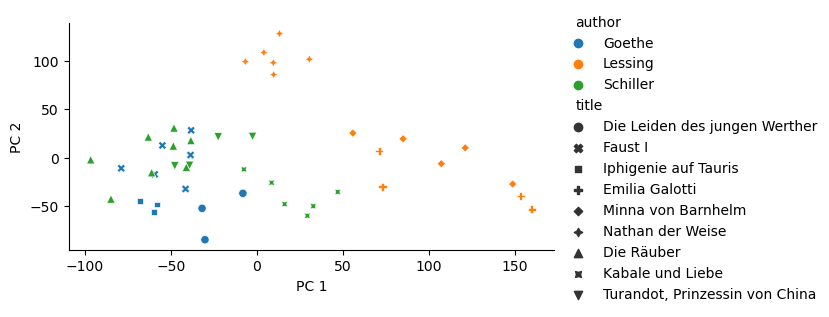

In [32]:
sns.relplot(data=freqs, x="PC 1", y="PC 2", hue="author", style = "title", aspect = 2, height=3)

In der zweidimensionalen Visualisierung erkennt man bereits deutliche Unterschiede zwischen Lessing und den beiden anderen Autoren. Zwischen Goethe und Schiller zu unterscheiden ist jedoch nicht direkt möglich.

In [20]:
fig = px.scatter_3d(freqs, x="PC 1", y="PC 2", z="PC 3", color="author", symbol = "title")
fig.show()

Durch Hinzunahme der dritten Hauptkomponente sind auch Goethe und Schiller voneinander trennbar. 

In [21]:
directions = pd.DataFrame({"word" : frequent_words})

directions[["PC 1", "PC 2", "PC 3"]] = pca.components_.T
directions.head(10)

,word,PC 1,PC 2,PC 3
0,ich,0.235112,0.071668,0.500397
1,und,-0.363455,-0.327753,0.431647
2,der,-0.047479,-0.230509,0.005153
3,die,-0.207558,-0.340000,0.158414
4,sie,0.724582,-0.465573,-0.008408
5,nicht,0.184676,0.301394,0.125270
6,zu,0.001018,0.062207,0.249979
7,das,0.000786,-0.000357,0.125495
8,ist,0.048293,-0.001261,0.065736
9,er,0.072297,0.170767,-0.273579


Nun ein Blick in die Richtungen der Hauptkomponenten, d.h. in die Koeffizienten der Linearkombinationen.

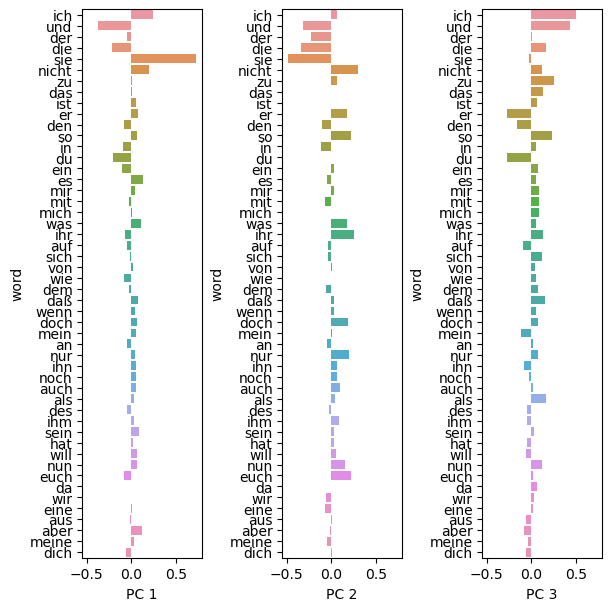

In [29]:
fix, axs = plt.subplots(1, 3, layout = "constrained", figsize = (6, 6), sharex=True)
sns.barplot(ax = axs[0], x=directions["PC 1"], y = directions["word"])
sns.barplot(ax = axs[1], x=directions["PC 2"], y = directions["word"])
sns.barplot(ax = axs[2], x=directions["PC 3"], y = directions["word"])
plt.show()

## Wer hat das unbekannte Buch geschrieben?

Wir gehen davon aus, dass im Arbeitsverzeichnis die Datei "unknown author - Reineke Fuchs.txt" liegt.
Der Code ist identisch zu oben. (Sinnvollerweise hätte man ihn oben direkt als Funktion geschrieben um hier eine Codedopplung zu vermeiden.)

In [25]:
chunksize = 5000
frequency_vectors = []

for p in list(Path().glob("unknown author - Reineke Fuchs.txt")):
    filename = str(p)
    print(filename)
    author = re.search(r"(.*) - ", filename).groups()[0]
    title = re.search(r" - (.*)\.txt", filename).groups()[0]
    text = p.read_text()
    text = text.lower()
    words = re.split(r"[\W_]+", text) # \W = non-word characters
    
    chunks = [words[idx : idx+chunksize] for idx in range(0, len(words), chunksize)]
    for chunk in chunks:
        # count the frequencies (but only of the globally frequent words)
        word_counter = {}
        for word in frequent_words:
            word_counter[word] = 0
        for word in chunk:
            if word in frequent_words:
                word_counter[word] = word_counter[word] + 1

        word_counter["author"] = author
        word_counter["title"] = title
        word_counter["chunksize"] = len(chunk)
        frequency_vectors.append(word_counter)

freqs_new = pd.DataFrame(frequency_vectors)
freqs_new = freqs_new[freqs_new["chunksize"] == chunksize] # eliminate small blocks (end of book)
freqs_new

unknown author - Reineke Fuchs.txt


,ich,und,der,die,sie,nicht,zu,das,ist,er,...,euch,da,wir,eine,aus,aber,meine,author,title,chunksize
0,86,231,123,118,47,29,79,43,21,157,...,34,25,9,9,7,24,5,unknown author,Reineke Fuchs,5000
1,130,231,91,98,59,42,95,47,21,125,...,39,34,18,3,7,21,6,unknown author,Reineke Fuchs,5000
2,122,244,100,120,52,43,79,53,18,106,...,33,27,14,4,9,16,10,unknown author,Reineke Fuchs,5000
3,132,246,85,90,56,50,102,57,31,107,...,46,26,19,1,3,21,9,unknown author,Reineke Fuchs,5000
4,140,265,81,121,101,62,94,69,27,81,...,41,23,24,4,5,24,6,unknown author,Reineke Fuchs,5000
5,123,236,104,123,114,56,85,53,26,91,...,29,30,13,1,12,16,8,unknown author,Reineke Fuchs,5000
6,115,254,78,122,77,62,78,52,19,94,...,31,26,13,4,5,13,5,unknown author,Reineke Fuchs,5000
7,169,220,60,99,66,56,99,58,22,93,...,70,28,15,4,9,21,13,unknown author,Reineke Fuchs,5000


In [27]:
freqs_new[["PC 1", "PC 2", "PC 3"]] = pca.transform(freqs_new.iloc[:, 0:50])
freqs_new

,ich,und,der,die,sie,nicht,zu,das,ist,er,...,eine,aus,aber,meine,author,title,chunksize,PC 1,PC 2,PC 3
0,86,231,123,118,47,29,79,43,21,157,...,9,7,24,5,unknown author,Reineke Fuchs,5000,-64.364337,-31.441019,5.762559
1,130,231,91,98,59,42,95,47,21,125,...,3,7,21,6,unknown author,Reineke Fuchs,5000,-45.821161,-15.717635,42.612064
2,122,244,100,120,52,43,79,53,18,106,...,4,9,16,10,unknown author,Reineke Fuchs,5000,-57.979291,-33.919110,47.566880
3,132,246,85,90,56,50,102,57,31,107,...,1,3,21,9,unknown author,Reineke Fuchs,5000,-41.999734,-12.164324,66.073307
4,140,265,81,121,101,62,94,69,27,81,...,4,5,24,6,unknown author,Reineke Fuchs,5000,-19.182004,-46.494586,92.030409
5,123,236,104,123,114,56,85,53,26,91,...,1,12,16,8,unknown author,Reineke Fuchs,5000,-11.820748,-58.289275,51.164167
6,115,254,78,122,77,62,78,52,19,94,...,4,5,13,5,unknown author,Reineke Fuchs,5000,-43.464521,-37.580336,52.217235
7,169,220,60,99,66,56,99,58,22,93,...,4,9,21,13,unknown author,Reineke Fuchs,5000,-28.689387,5.597444,70.695525


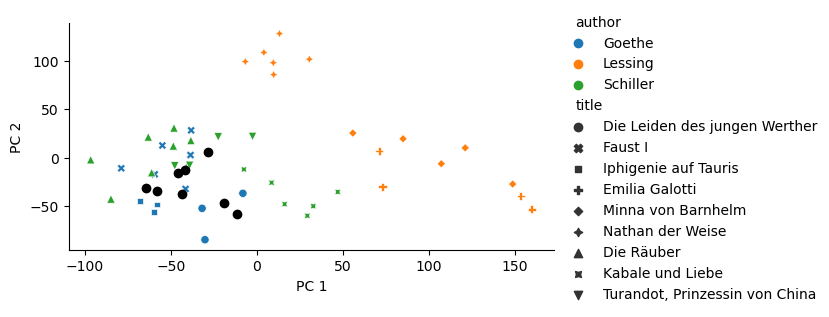

In [29]:
g = sns.relplot(data=freqs, x="PC 1", y="PC 2", hue="author", style = "title", aspect = 2, height=3)
g.ax.scatter(x=freqs_new["PC 1"], y=freqs_new["PC 2"], color = "black")
plt.show()

Der unbekannte Text ist gemäß der zweidimensionalen Projektion vermeindlich von Goethe oder Schiller. Eine genauere Unterscheidung ist hier nicht möglich.

Nimmt man hingegen die dritte Hauptkomponente hinzu, so sind die schwarzen Punkte relativ gut Goethe zuzuordnen. Tatsächlich stammt der Text *Reineke Fuchs* von Goethe.

In [31]:
fig  = px.scatter_3d(freqs,     x="PC 1", y="PC 2", z="PC 3", color="author", symbol = "title")
fig2 = px.scatter_3d(freqs_new, x="PC 1", y="PC 2", z="PC 3", color="author", symbol = "title", color_discrete_sequence=['rgb(0, 0, 0)'])

fig.add_traces(fig2.data)
fig.show()